![alt text](https://upload.wikimedia.org/wikipedia/commons/2/22/ENSAE_logo_developpe.jpg)

# Compressed Sensing Project

## [Paper] Network Reconstruction under Compressive Sensing

In this paper, the authors present a compressed sensing based method to reconstruct any network (under some relatively weak assumptions). In this notebook we will be trying to reconstruct parts of a neural network of neurons and synapses in **C. elegans**, a type of worm.

#### Some imports and global variables :

Imports :

In [3]:
import warnings
warnings.filterwarnings(action='ignore')

import numpy as np
import pandas as pd
import networkx as nx

from matplotlib import pylab as plt
import seaborn as sns

%matplotlib inline
plt.rcParams["figure.figsize"] = (18, 8)

sns.set_style("whitegrid")
sns.set_context("talk")

np.random.seed(10)

Plot parameters :

In [4]:
DRAW_GRAPH_PARAMS = dict(
    with_labels=False, node_color='#19527F',
    node_size=500, edge_color="#637A99")

DRAW_TREE_PARAMS = dict(
    with_labels=False, node_color='#FF4C4C',
    node_size=550, edge_color="#FF4C4C")

Let's load the dataset containing all the neural connections :

In [5]:
def load_elegans_frontal_neural_network_graph():
    data = []
    with open("data/C-elegans-frontal.txt", 'r') as f:
        for line in f.readlines():
            line = line.strip()
            if line[0] == '#':
                pass
            else:
                l = list(map(int, line.split(' ')))
                data.append(l)

    graph = nx.DiGraph()
    graph.add_edges_from(data)
    return graph

... and plot the network to have a quick preview of what it looks like :

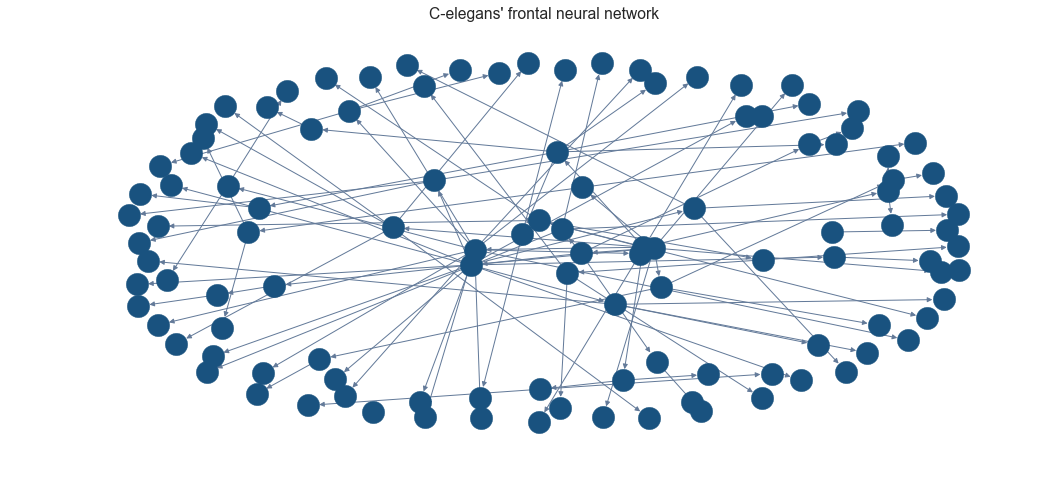

In [29]:
graph = load_elegans_frontal_neural_network_graph()
graph = nx.bfs_tree(graph, source=0, reverse=True)

N_NODES = len(graph.nodes())
NODE_POSITIONS = {node: np.random.uniform(size=2) for node in range(N_NODES)}

graph = nx.subgraph(graph, range(N_NODES))

plt.title("C-elegans' frontal neural network")
nx.draw(graph, **DRAW_GRAPH_PARAMS)

## Data simulation

The paper shows how to reconstruct a network based on particular constructs called **cascades**. These cascades represent the random propagation of an information from a single node to its successors. Unfortunately, the main python package ```networkx``` that deals with networks can only return the tree composed of an initial node and all its successor nodes. So, we will need to add some randomness to some of the package's functions to generate random cascades instead of whole trees.

### Adding randomness to some networkx functions

In [14]:
from collections import deque

def generic_bfs_edges(G, source, neighbors=None):
    """Iterate over edges in a breadth-first search."""
    visited = {source}
    queue = deque([(source, neighbors(source))])
    while queue:
        parent, children = queue[0]
        try:
            child = next(children)
            if child not in visited:
                yield parent, child
                visited.add(child)
                queue.append((child, neighbors(child)))
        except StopIteration:
            queue.popleft()

def bfs_edges(G, source, beta):
    """Iterate over edges in a breadth-first-search starting at source."""
    def successors(node):
        for neighbor in G.neighbors(node):
            if np.random.random() < beta:
                yield neighbor

    for e in generic_bfs_edges(G, source, successors):
        yield e

def random_subset_of_successors(G, source, beta):
    """Returns an iterator of successors in breadth-first-search from source."""
    parent = source
    children = []
    for p, c in bfs_edges(G, source, beta):
        if p == parent:
            children.append(c)
            continue
        yield (parent, children)
        children = [c]
        parent = p
    yield (parent, children)

The ```random_subset_of_successors``` function starts from an initial node called ```source``` then propagates with probability $\beta$ at each node and returns the list of (nodes, successors).

### Generating cascades 

A **cascade** is timed in the sense that each node is associated with a hit time that corresponds to when the information got to that particular node. The network reconstitution problem comes from the fact that we can't directly observe the cascade as a whole, instead, we can only see if and when an information got to a given node.

We will be relying on ```TimedEdges``` and ```TimedNodes``` constructs. A TimedEdge is a tuple (u, v, t) where u is the parent node, v is the child node and t is the time the info propagated from u to v. A TimedNode is simple a TimedEdge where we don't know the parent node. Using these constructs, a cascade is simple an ordered list of TimedEdges, and when we observe a network, we can only see an list of TimedNodes.

In [15]:
from collections import namedtuple

TimedEdge = namedtuple('TimedEdge', 'u v t')
TimedNode = namedtuple('TimedNode', 'v t')

In [16]:
def make_cascades(graph, n_cascades, beta=0.7):
    cascades = []
    for _ in range(n_cascades):
        initial_node = np.random.choice(graph.nodes())
        cascade = [TimedEdge(-1, initial_node, 0)]

        i = 1
        for node, successors in random_subset_of_successors(graph, initial_node, beta):
            for successor in successors:
                cascade.append(TimedEdge(node, successor, i))
                i += 1
        cascades.append(cascade)
    return cascades

Examples of a cascade :

In [25]:
example_cascades = make_cascades(graph, n_cascades=3)
for cascade in example_cascades:
    print(cascade)
    print()

[TimedEdge(u=-1, v=80, t=0), TimedEdge(u=80, v=38, t=1)]

[TimedEdge(u=-1, v=69, t=0), TimedEdge(u=69, v=63, t=1), TimedEdge(u=69, v=75, t=2), TimedEdge(u=69, v=81, t=3), TimedEdge(u=63, v=93, t=4), TimedEdge(u=63, v=121, t=5)]

[TimedEdge(u=-1, v=12, t=0), TimedEdge(u=12, v=7, t=1)]



Corresponding observations :

In [26]:
for cascade in example_cascades:
    print([TimedNode(v, t) for (u, v, t) in cascade])
    print()

[TimedNode(v=80, t=0), TimedNode(v=38, t=1)]

[TimedNode(v=69, t=0), TimedNode(v=63, t=1), TimedNode(v=75, t=2), TimedNode(v=81, t=3), TimedNode(v=93, t=4), TimedNode(v=121, t=5)]

[TimedNode(v=12, t=0), TimedNode(v=7, t=1)]



We can also visualize a given cascade for example :

In [30]:
def tree_from_cascade(cascade):
    tree = nx.DiGraph()
    labels = {}
    for u, v, t in cascade:
        if u == -1:
            tree.add_node(v)
            labels[v] = 0
        else:
            tree.add_edge(u, v)
            labels[v] = t
    return tree, labels

def draw_cascade(cascade):
    tree, labels = tree_from_cascade(cascade)
    
    nx.draw_networkx_edges(graph, NODE_POSITIONS, alpha=0.3, **DRAW_GRAPH_PARAMS)
    nx.draw_networkx_nodes(graph, NODE_POSITIONS, **DRAW_GRAPH_PARAMS)
    
    nx.draw_networkx_labels(tree, NODE_POSITIONS, labels)
    nx.draw(tree, NODE_POSITIONS, **DRAW_TREE_PARAMS)

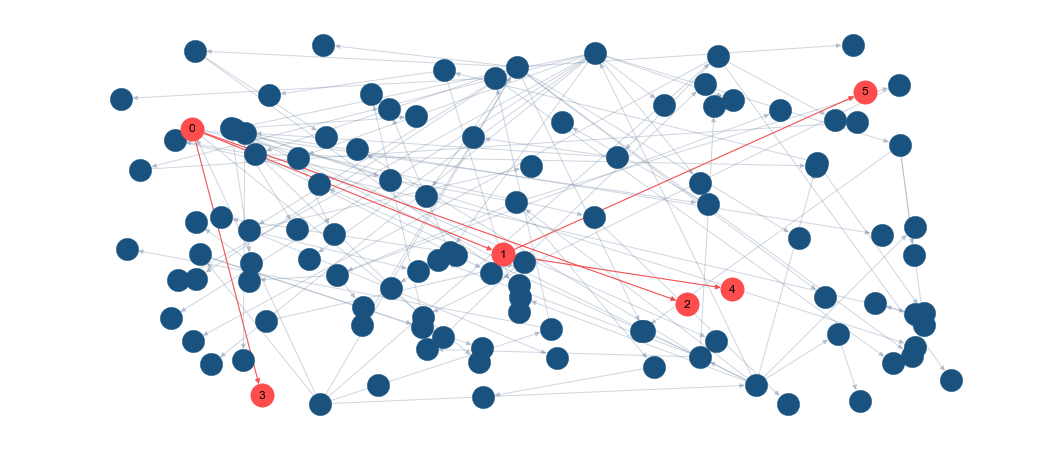

In [31]:
draw_cascade(example_cascades[1])

## Implementation

Now that we are able to simulate some cascades and get the corresponding observations, let's implement the **CS-RecNet** algorithm.

**Algorithm :**
For each cascade $c$ (Which forms each equation in the linear system):

- We find the most probable tree and set it to $T^∗_c$.


- For each possible edge in $G$, we calculate the edge transmission log probabilities.  
In particular, for each edge in $T^∗_c$ we use logarithm of Eq.(6) of the paper and for the rest of the edges in $G$ we consider zero probability.


- We calculate LP(c|G) = log P(c|G) from Eq.(9) and add it as a row to the vector $y$.


- We form the vector vLP(c|$T^∗_c$) from the previous step and add it as a row to the matrix $A$.

### 1 - Finding the most probable tree given an observation :

We will rely on this most probable tree to compute our sensing matrix and observed signal.

In [32]:
def proba_of_edge_given_obs(u, v, obs, alpha):
    """Computes the conditional probability of a cascade spreading
    from node (u) to node (v) given an observation (obs)."""

    node_to_time = dict(obs)
    reached_nodes = node_to_time.keys()
    if (u in reached_nodes) and (v in reached_nodes):
        time_u = node_to_time[u]
        time_v = node_to_time[v]
        if time_v > time_u:
            return np.exp(-(time_v - time_u)/alpha)
        else:
            return 0  # can't have an edge from u to v if v was reached before u
    else:
        return 0  # can't have an edge from u to v if none were reached

In [33]:
def most_probable_cascade_given_obs(observation, alpha):
    v, t = observation[0]
    cascade = [TimedEdge(-1, v, t)]  # initial timed edge of the cascade

    node_to_time = dict(observation)
    for v, t in list(node_to_time.items())[1:]:
        search = -1
        largest_proba = 0
        for u in node_to_time.keys():
            proba = proba_of_edge_given_obs(u, v, observation, alpha)
            if proba > largest_proba:
                largest_proba = proba
                search = u
        if search != -1:  # if there are nodes with non-zero proba
            cascade.append(TimedEdge(search, u, node_to_time[u]))  # add the one with largest proba
    return cascade

### 2 - Computing sensing matrix :

The sensing matrix in this problem is the matrix where each line is the list of transmission log-probabilities for most probable tree given an observation.

In [35]:
def compute_sensing_matrix(graph, observations, alpha):
    nodes = list(graph.nodes())
    edge_order = [(i, j) for i in nodes for j in nodes]
    
    A = []
    for observation in observations:
        obs = dict(observation)
        
        log_probs = []
        for edge in edge_order:
            u, v = edge
            if (u in obs.keys()) and (v in obs.keys()):
                prob = proba_of_edge_given_obs(u, v, observation, alpha)
                if prob != 0:
                    log_probs.append(np.log(prob))
                else:
                    log_probs.append(0)
            else:
                log_probs.append(0)
        A.append(log_probs)
    return np.array(A).astype(float)

### 3 - Computing the log-probability of the most probable tree :

This will be used to compute the observed signal.

In [36]:
def most_probable_cascade_probability(graph, observation, beta, alpha):
    cascade = most_probable_cascade_given_obs(observation, alpha)
    cascade_edges = [(u, v) for u, v, t in cascade if u!= -1]
    cascade_nodes = list(set([u for u, v in cascade_edges] + [v for u, v in cascade_edges]))
    
    n = len(cascade_nodes)
    if n:
        possible_edges_given_nodes = [(u, v) for u, v in graph.edges() if u in cascade_nodes]
        proba = 1
        for edge in possible_edges_given_nodes:
            if edge in cascade_edges:
                u, v = edge
                proba *= beta
                proba *= proba_of_edge_given_obs(u, v, observation, alpha)
            else:
                proba *= (1-beta)
        
        return np.log(proba / (n**(n-1)))
    else:
        return np.log(1)

## Experiment

Now that we defined all the functions we need to use CS-RecNet, let's define a final function that takes a list of observed cascades, creates a sensing matrix A and an observed signal y then uses Basis Pursuit on that to predict the edges of the network :

In [68]:
from tqdm import tqdm
from sklearn.metrics import f1_score
from cvxopt import matrix, solvers, sparse, sparse, spmatrix, spdiag
solvers.options['show_progress'] = False # No logs printed

def cvx_mat(A, y):
    '''A, y: numpy array or cvx matrices
    return parameters c, G, h, A, b for CVXOPT solvers.lp method'''
    A = matrix(A)
    y = matrix(y)
    m, N = matrix(A).size
    # matrix c, G, h, A, b
    c = matrix(np.ones(2*N))
    G = -spdiag([1]*2*N)
    h = matrix(np.zeros(2*N))
    A = matrix([[A],[-A]])
    b = y
    return c, G, h, A, b

def solve(A, y):
    N = A.shape[1]
    c, G, h, A, b = cvx_mat(A, y)
    sol = solvers.lp(c, G, h, A, b, solver = 'glpk')
    sol = sol['x']
    try:
        x_recover = sol[0:N] - sol[N:2*N]
    except TypeError:  # 'NoneType' object is not subscriptable
        x_recover = np.zeros(N)
    return np.array(x_recover)

def CS_RecNet(graph, observations, alpha, beta, threshold):
    A = np.asmatrix(compute_sensing_matrix(graph, observations, alpha))
    y = np.array([most_probable_cascade_probability(graph, obs, beta, alpha) for obs in observations])
    
    predicted_x = solve(A, y)
    predicted_x = (predicted_x > threshold).astype(int)
    return predicted_x

Now let's test the algorithm on several cases :

### Case 1 - Network with no edges :

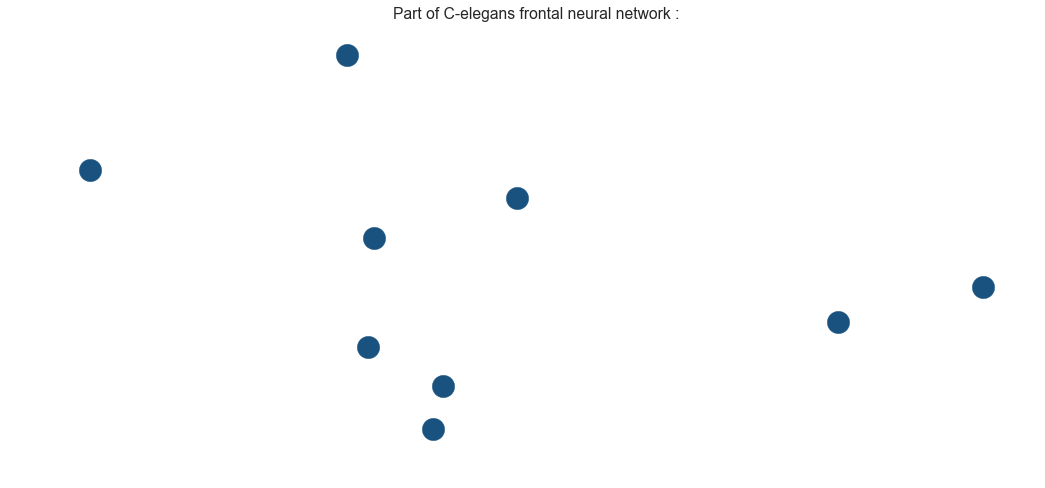

In [39]:
N_NODES = 10
NODE_POSITIONS = {node: np.random.uniform(size=2) for node in range(N_NODES)}

graph = load_elegans_frontal_neural_network_graph()
graph = nx.bfs_tree(graph, source=0, reverse=True)
graph = nx.subgraph(graph, range(N_NODES))

plt.title("Part of C-elegans frontal neural network :")
nx.draw(graph, NODE_POSITIONS, **DRAW_GRAPH_PARAMS)

In [40]:
real_x = nx.adjacency_matrix(graph).todense().reshape(-1, 1)
print(f"number of possible edges: {len(real_x)}")
n_edges = len(graph.edges())
print(f"actual number of edges: {n_edges}")

number of possible edges: 81
actual number of edges: 0


Let's generate some random cascades and their corresponding observations :

In [41]:
n = 5
cascades = make_cascades(graph, n_cascades=int(n))
observations = [[TimedNode(v, t) for (u, v, t) in cascade] for cascade in cascades]

Predict the edges using the algorithm :

In [43]:
predicted_x = CS_RecNet(graph, observations, alpha=0.1, beta=0.5, threshold=0.5)

Plot the results :

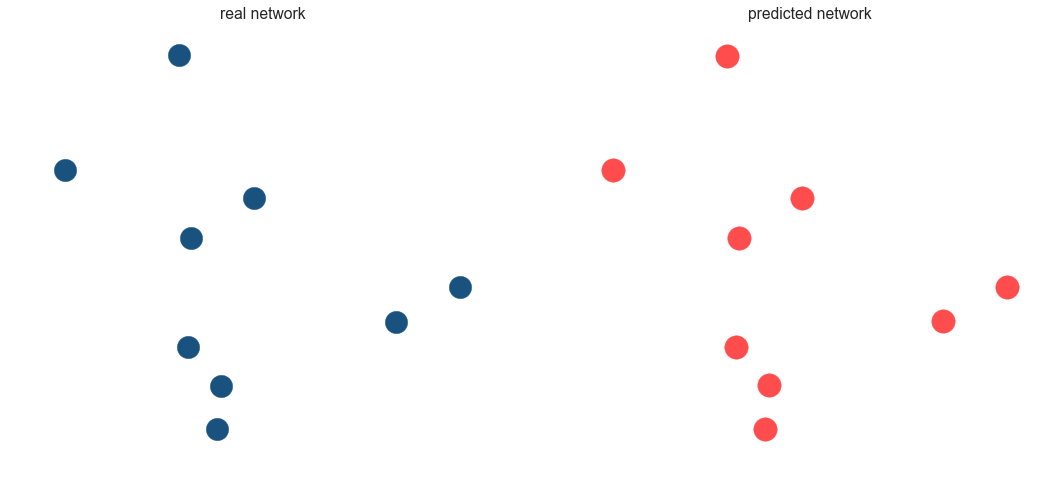

In [44]:
k = len(graph.nodes)

plt.subplot(121)
plt.title("real network")
nx.draw(nx.from_numpy_array(real_x.reshape(k, k)), NODE_POSITIONS, **DRAW_GRAPH_PARAMS)

plt.subplot(122)
plt.title("predicted network")
nx.draw(nx.from_numpy_array(predicted_x.reshape(k, k)), NODE_POSITIONS, **DRAW_TREE_PARAMS)

This is relieving as it is the simplest case possible. Now let's carry on to some actual network reconstruction.

### Case 2 - Small network :

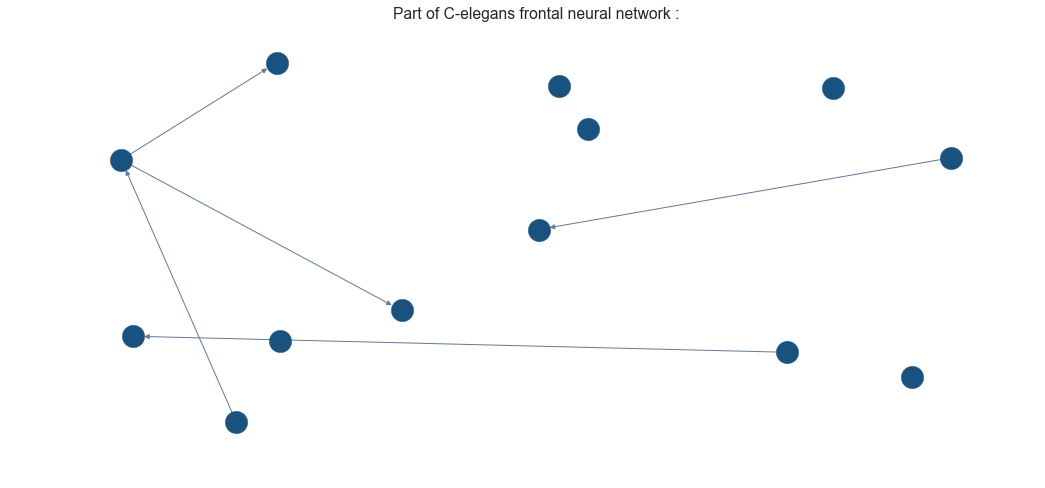

In [77]:
N_NODES = 14
NODE_POSITIONS = {node: np.random.uniform(size=2) for node in range(N_NODES)}

graph = load_elegans_frontal_neural_network_graph()
graph = nx.bfs_tree(graph, source=0, reverse=True)
graph = nx.subgraph(graph, range(N_NODES))

plt.title("Part of C-elegans frontal neural network :")
nx.draw(graph, NODE_POSITIONS, **DRAW_GRAPH_PARAMS)

In [78]:
real_x = nx.adjacency_matrix(graph).todense().reshape(-1, 1)
print(f"number of possible edges: {len(real_x)}")

n_edges = len(graph.edges())
print(f"actual number of edges: {n_edges}")

number of possible edges: 169
actual number of edges: 5


Here, the choice of the number of observations is important, so let's see how the results evolve when this number changes :

100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


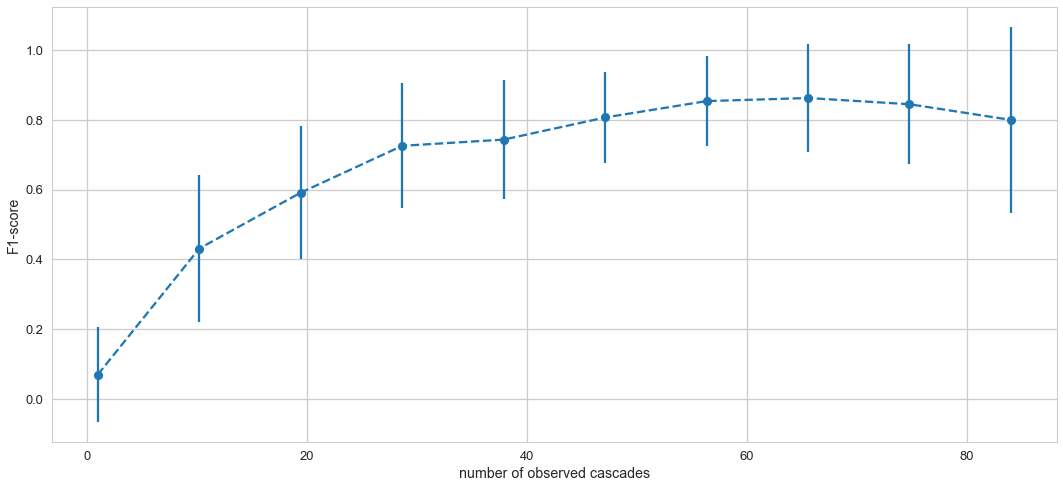

In [79]:
mean = []  # a list to save the average F1-scores
std = []  # a list for the standard deviations

space = np.linspace(1, len(real_x)//2, 10)
for n in tqdm(space):
    scores = []
    for _ in range(100):
        cascades = make_cascades(graph, n_cascades=int(n))
        observations = [[TimedNode(v, t) for (u, v, t) in cascade] for cascade in cascades]
        
        predicted_x = CS_RecNet(graph, observations, alpha=0.1, beta=0.5, threshold=0.5)        
        scores.append(f1_score(real_x, predicted_x))

    mean.append(np.mean(scores))
    std.append(np.std(scores))

plt.errorbar(space, mean, np.array(std), linestyle='--', marker='o')
plt.xlabel("number of observed cascades")
plt.ylabel("F1-score")
plt.show()

We can see that as the number of observation increases, we reach almost perfect reconstruction on this simple example.

In [87]:
n = 70

cascades = make_cascades(graph, n_cascades=int(n))
observations = [[TimedNode(v, t) for (u, v, t) in cascade] for cascade in cascades]

predicted_x = CS_RecNet(graph, observations, alpha=0.1, beta=0.5, threshold=0.5)

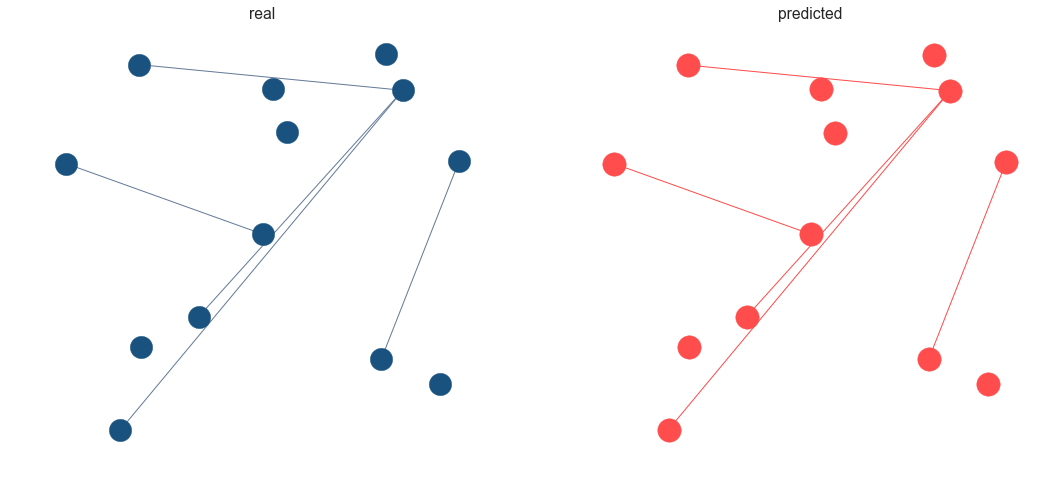

In [88]:
k = len(graph.nodes)

plt.subplot(121)
plt.title("real")
nx.draw(nx.from_numpy_array(real_x.reshape(k, k)), NODE_POSITIONS, **DRAW_GRAPH_PARAMS)

plt.subplot(122)
plt.title("predicted")
nx.draw(nx.from_numpy_array(predicted_x.reshape(k, k)), NODE_POSITIONS, **DRAW_TREE_PARAMS)

### Case 3 - Bigger network :

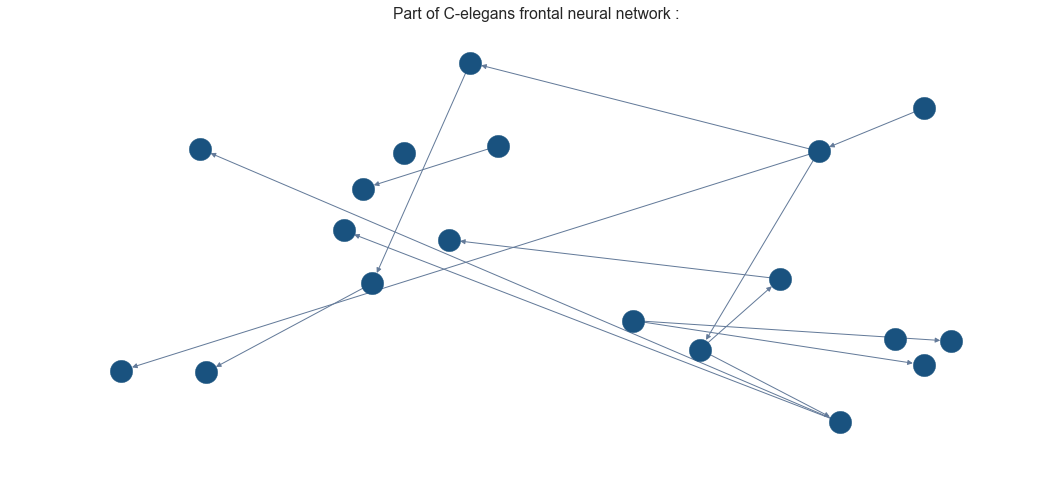

In [91]:
N_NODES = 20
NODE_POSITIONS = {node: np.random.uniform(size=2) for node in range(N_NODES)}

graph = load_elegans_frontal_neural_network_graph()
graph = nx.bfs_tree(graph, source=0, reverse=True)
graph = nx.subgraph(graph, range(N_NODES))

plt.title("Part of C-elegans frontal neural network :")
nx.draw(graph, NODE_POSITIONS, **DRAW_GRAPH_PARAMS)

In [92]:
real_x = nx.adjacency_matrix(graph).todense().reshape(-1, 1)
print(f"number of possible edges: {len(real_x)}")
n_edges = len(graph.edges())
print(f"actual number of edges: {n_edges}")

number of possible edges: 361
actual number of edges: 14


100%|██████████| 10/10 [01:26<00:00,  8.68s/it]


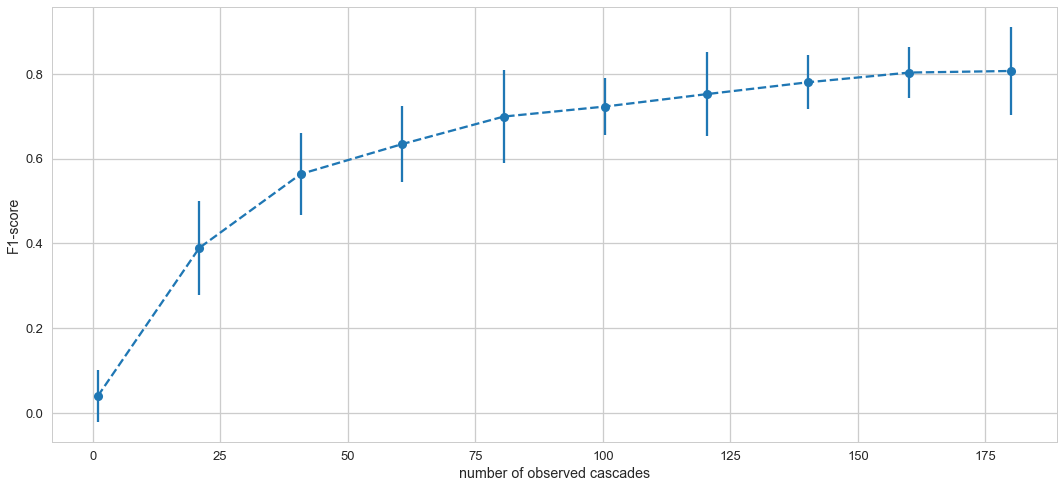

In [93]:
mean = []  # a list to save the average F1-scores
std = []  # a list for the standard deviations

space = np.linspace(1, len(real_x)//2, 10)
for n in tqdm(space):
    scores = []
    for _ in range(100):
        cascades = make_cascades(graph, n_cascades=int(n))
        observations = [[TimedNode(v, t) for (u, v, t) in cascade] for cascade in cascades]
        
        predicted_x = CS_RecNet(graph, observations, alpha=0.1, beta=0.5, threshold=0.5)        
        scores.append(f1_score(real_x, predicted_x))

    mean.append(np.mean(scores))
    std.append(np.std(scores))

plt.errorbar(space, mean, np.array(std), linestyle='--', marker='o')
plt.xlabel("number of observed cascades")
plt.ylabel("F1-score")
plt.show()

On this bigger network, the performance is slightly worse but still pretty good !

In [94]:
n=200

cascades = make_cascades(graph, n_cascades=int(n))
observations = [[TimedNode(v, t) for (u, v, t) in cascade] for cascade in cascades]

predicted_x = CS_RecNet(graph, observations, alpha=0.1, beta=0.5, threshold=0.5)

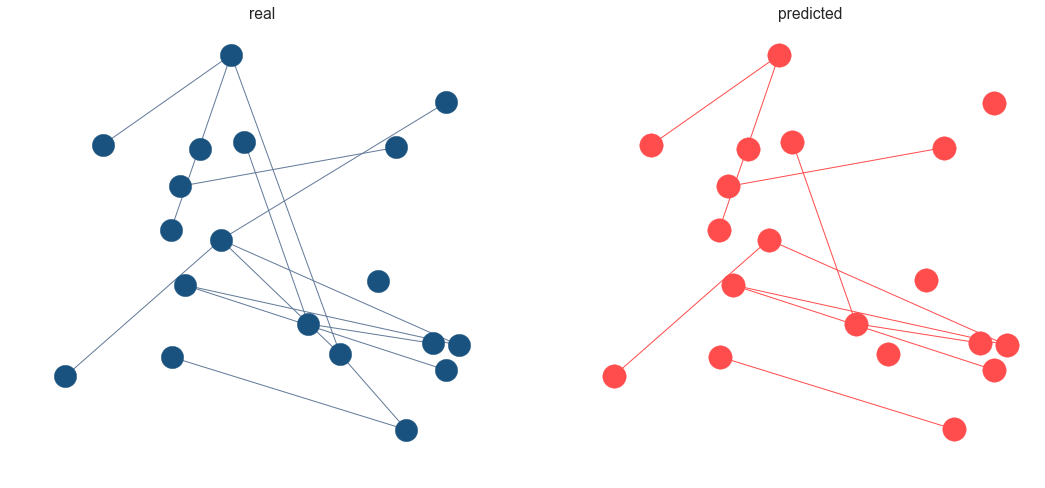

In [95]:
k = len(graph.nodes)

plt.subplot(121)
plt.title("real")
nx.draw(nx.from_numpy_array(real_x.reshape(k, k)), NODE_POSITIONS, **DRAW_GRAPH_PARAMS)

plt.subplot(122)
plt.title("predicted")
nx.draw(nx.from_numpy_array(predicted_x.reshape(k, k)), NODE_POSITIONS, **DRAW_TREE_PARAMS)

#### Quick test : what are the effects of $\alpha$, $\beta$ and the threshold ? 

100%|██████████| 10/10 [00:12<00:00,  1.27s/it]


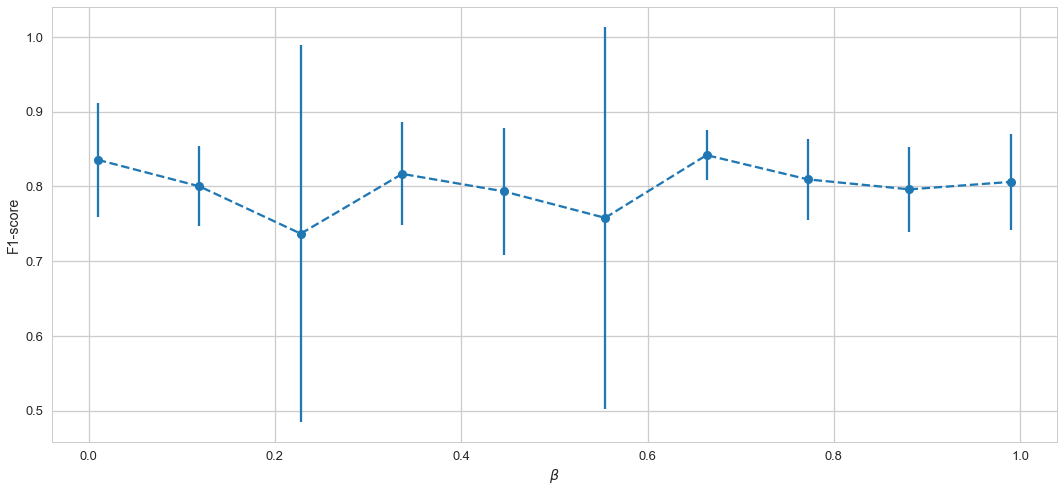

In [97]:
mean = []  # a list to save the average F1-scores
std = []  # a list for the standard deviations

space = np.linspace(0.01, 0.99, 10)
for beta in tqdm(space):
    scores = []
    for _ in range(10):
        cascades = make_cascades(graph, n_cascades=200)
        observations = [[TimedNode(v, t) for (u, v, t) in cascade] for cascade in cascades]
        
        predicted_x = CS_RecNet(graph, observations, alpha=0.1, beta=beta, threshold=0.5)        
        scores.append(f1_score(real_x, predicted_x))

    mean.append(np.mean(scores))
    std.append(np.std(scores))

plt.errorbar(space, mean, np.array(std), linestyle='--', marker='o')
plt.xlabel("$\\beta$")
plt.ylabel("F1-score")
plt.show()

Despite what the paper seems to claim, the effect of $\beta$ (at least in my implementation of the algo.) seems random.

100%|██████████| 10/10 [00:12<00:00,  1.24s/it]


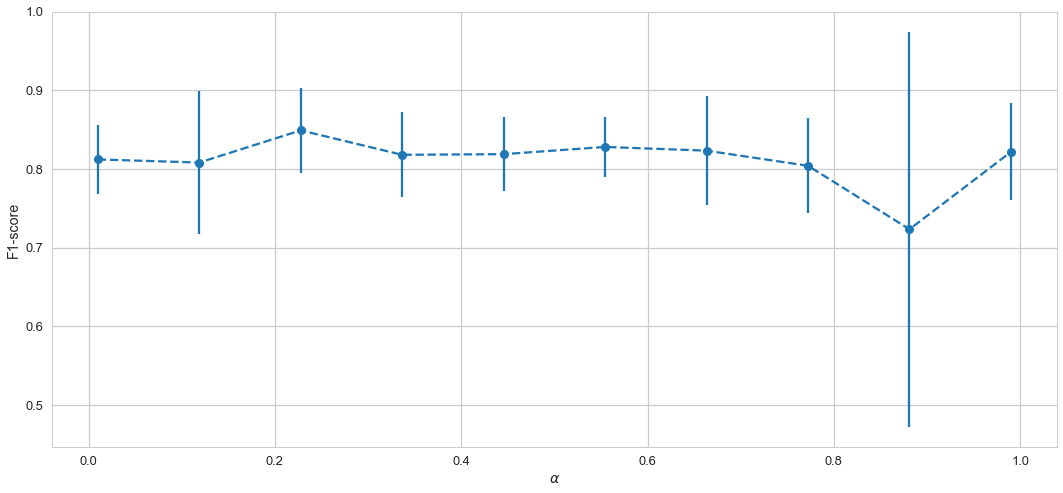

In [98]:
mean = []  # a list to save the average F1-scores
std = []  # a list for the standard deviations

space = np.linspace(0.01, 0.99, 10)
for alpha in tqdm(space):
    scores = []
    for _ in range(10):
        cascades = make_cascades(graph, n_cascades=200)
        observations = [[TimedNode(v, t) for (u, v, t) in cascade] for cascade in cascades]
        
        predicted_x = CS_RecNet(graph, observations, alpha=alpha, beta=0.5, threshold=0.5)        
        scores.append(f1_score(real_x, predicted_x))

    mean.append(np.mean(scores))
    std.append(np.std(scores))

plt.errorbar(space, mean, np.array(std), linestyle='--', marker='o')
plt.xlabel("$\\alpha$")
plt.ylabel("F1-score")
plt.show()

Same thing for the effect of $\alpha$. This might mean that our implementation isn't 100% correct.

### Case 4 - Whole network :

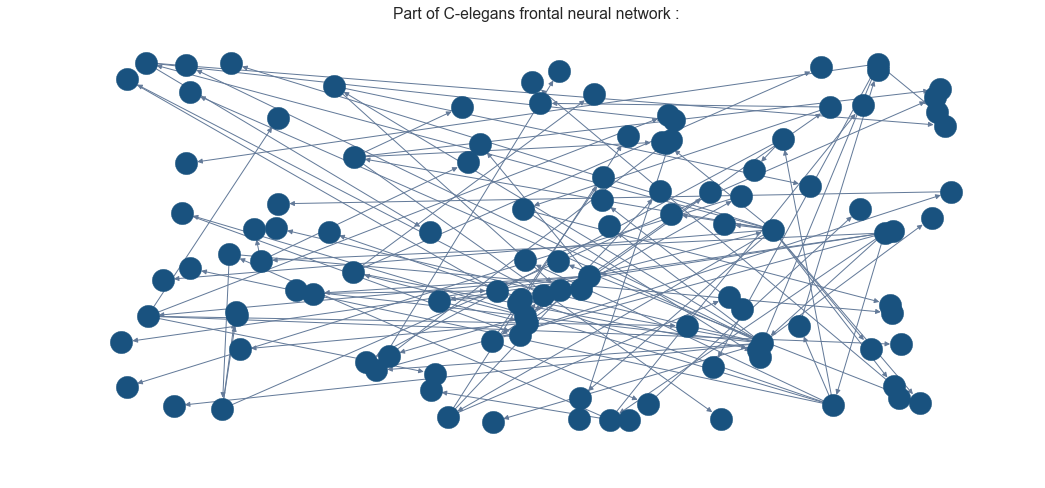

In [111]:
graph = load_elegans_frontal_neural_network_graph()
graph = nx.bfs_tree(graph, source=0, reverse=True)

N_NODES = len(graph.nodes())
NODE_POSITIONS = {node: np.random.uniform(size=2) for node in range(N_NODES)}

graph = load_elegans_frontal_neural_network_graph()
graph = nx.bfs_tree(graph, source=0, reverse=True)
graph = nx.subgraph(graph, range(N_NODES))

plt.title("Part of C-elegans frontal neural network :")
nx.draw(graph, NODE_POSITIONS, **DRAW_GRAPH_PARAMS)

In [112]:
real_x = nx.adjacency_matrix(graph).todense().reshape(-1, 1)
print(f"number of possible edges: {len(real_x)}")

n_edges = len(graph.edges())
print(f"actual number of edges: {n_edges}")

number of possible edges: 12769
actual number of edges: 110


100%|██████████| 10/10 [1:04:08<00:00, 384.85s/it]


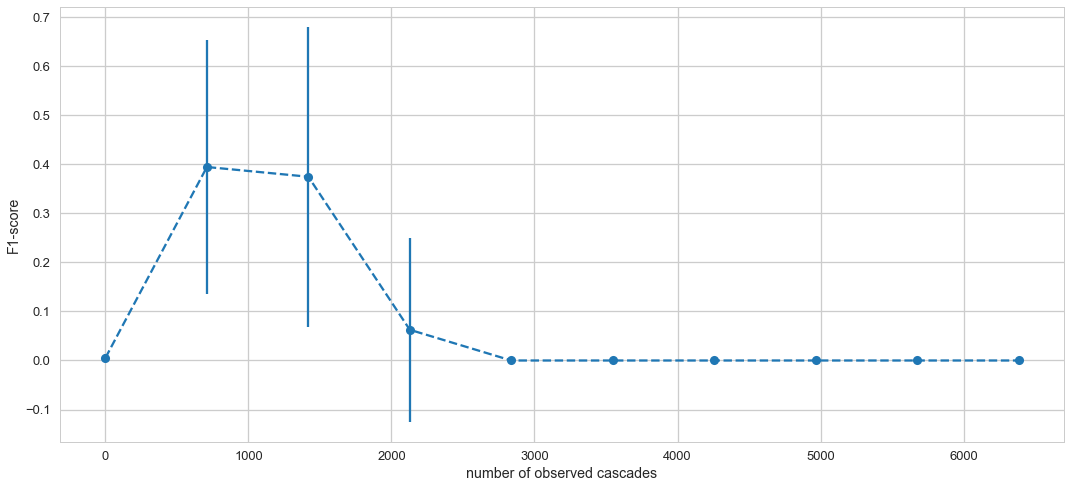

In [113]:
mean = []  # a list to save the average F1-scores
std = []  # a list for the standard deviations

space = np.linspace(1, len(real_x)//2, 10)
for n in tqdm(space):
    scores = []
    for _ in range(10):
        cascades = make_cascades(graph, n_cascades=int(n))
        observations = [[TimedNode(v, t) for (u, v, t) in cascade] for cascade in cascades]
        
        predicted_x = CS_RecNet(graph, observations, alpha=0.1, beta=0.5, threshold=0.5)        
        scores.append(f1_score(real_x, predicted_x))

    mean.append(np.mean(scores))
    std.append(np.std(scores))

plt.errorbar(space, mean, np.array(std), linestyle='--', marker='o')
plt.xlabel("number of observed cascades")
plt.ylabel("F1-score")
plt.show()

The method seems to not be working for a large number of cascades, this might be because the number of observations is too high compared to the size of the signal X. But we see nonetheless that the reconstruction can reach almost 70% in some cases, but the standard deviation of these results is too high to be reliable in a one-shot prediction situation.

As a final test, let's try another optimization procedure for solving the compressed sensing problem : Orthogonal Matching Pursuit (OMP), but this time instead of using a linear space for the parameter ```n_cascades``` we will use a logspace to focus more on the smaller values.

100%|██████████| 10/10 [18:23<00:00, 110.31s/it]


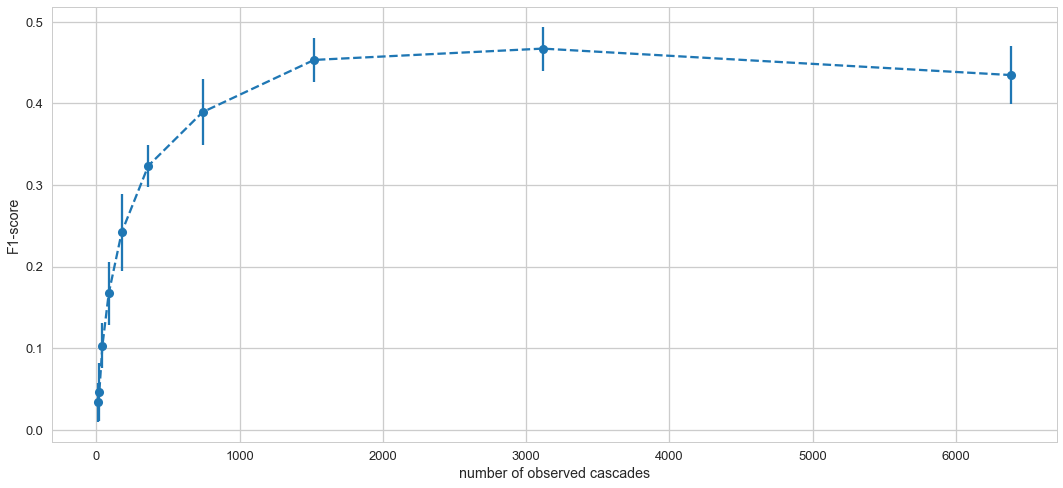

In [146]:
from sklearn.linear_model import OrthogonalMatchingPursuit

mean = []  # a list to save the average F1-scores
std = []  # a list for the standard deviations

space = np.logspace(1, np.log10(len(real_x)//2), 10)
for n in tqdm(space):
    scores = []
    for _ in range(10):
        cascades = make_cascades(graph, n_cascades=int(n))
        observations = [[TimedNode(v, t) for (u, v, t) in cascade] for cascade in cascades]

        A = np.asmatrix(compute_sensing_matrix(graph, observations, alpha=0.1))
        y = np.array([most_probable_cascade_probability(graph, obs, beta=0.5, alpha=0.1) for obs in observations])

        model = OrthogonalMatchingPursuit()
        model.fit(A, y)
        coef = model.coef_
        predicted_x = (coef > 0.5).astype(int)

        scores.append(f1_score(real_x, predicted_x))

    mean.append(np.mean(scores))
    std.append(np.std(scores))

plt.errorbar(space, mean, np.array(std), linestyle='--', marker='o')
plt.xlabel("number of observed cascades")
plt.ylabel("F1-score")
plt.show()

```Scikit-lean```'s OMP infers a maximum number of non-zero values in the signal X as 10% of the size of X. Knowing that the number of edges in the network are 110 vs. 12769, this seems to be right in our case. Nonetheless, it seems like no real improvement will be made using OMP instead of BP as the average scores are around the same values in both cases. One thing to note would be that OMP's performance doesn't decrease when the number of observations increases, which is a desired feature in a model. The model F1-scores also have a significatively smaller variance, which is another good thing OMP has over BP. That being said, BP sometimes reaches higher scores when the number of observations is low enough.

#### A plot of the whole network, reconstructed

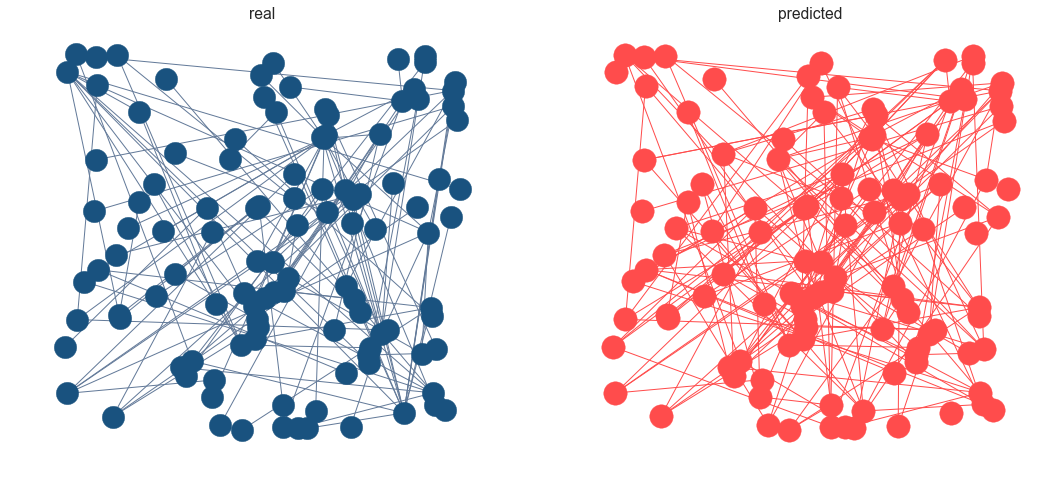

In [148]:
k = len(graph.nodes)

plt.subplot(121)
plt.title("real")
nx.draw(nx.from_numpy_array(real_x.reshape(k, k)), NODE_POSITIONS, **DRAW_GRAPH_PARAMS)

plt.subplot(122)
plt.title("predicted")
nx.draw(nx.from_numpy_array(predicted_x.reshape(k, k)), NODE_POSITIONS, **DRAW_TREE_PARAMS)